# Estudo com a série histórica dos sorteios da MS

### Estudo simples para avaliação de probabilidade de acerto de um sorteio. Não existe uma receita ou resposta exata, mas sim os resultados mais prováveis, ou seja, sem causalidade ou casualidade. Simplesmente, probabilidade.

### Após extrair a série histórica, vamos estruturar os dados com as informações que nos interessam

In [1]:
import json
import datetime
import pandas as pd

In [6]:
# ler o arquivo dump dos resultados
file = "bucket/contest_results.raw"
with open(file, 'r') as reader:
    resp = reader.read()
    
results = "[" + resp.replace("\n",", ") + "]" # gambs... :)
results = json.loads(results)
#results # debug

In [10]:
# função para mapear campos que interessam
def mapKeys(obj):
    resultDict = {}
    c=0
    for x in obj['resultado'].split('-'):
        resultDict['p'+str(c)] = x
        c+=1
    newObj = {}
    newObj['concurso'] = obj['concurso']
    newObj['data'] = datetime.datetime.fromtimestamp( int(str(obj['data']).zfill(13)[0:10]) ).strftime("%Y-%m-%d")
    newObj['resultado'] = obj['resultado'].split('-')
    newObj['resultado_p1'] = resultDict['p0']
    newObj['resultado_p2'] = resultDict['p1']
    newObj['resultado_p3'] = resultDict['p2']
    newObj['resultado_p4'] = resultDict['p3']
    newObj['resultado_p5'] = resultDict['p4']
    newObj['resultado_p6'] = resultDict['p5']
    newObj['resultado_soma_total'] = int(resultDict['p0'])+int(resultDict['p1'])+int(resultDict['p2'])+int(resultDict['p3'])+int(resultDict['p4'])+int(resultDict['p5'])
    newObj['valor'] = obj['valor']
    newObj['valor_quina'] = obj['valor_quina']
    newObj['valor_quadra'] = obj['valor_quadra']
    newObj['ganhadores'] = obj['ganhadores']
    newObj['ganhadores_quina'] = obj['ganhadores_quina']
    newObj['ganhadores_quadra'] = obj['ganhadores_quadra']
    newObj['acumulado'] = obj['acumulado']
    newObj['valor_acumulado'] = obj['valor_acumulado']
    newObj['vr_arrecadado'] = obj['vr_arrecadado']
    newObj['vr_acumulado_especial'] = obj['vr_acumulado_especial']
    #newObj['sg_uf'] = obj['sg_uf']
    #newObj['no_cidade'] = obj['no_cidade']
    newObj['ganhadoresPorUf'] = list(map(lambda x: {"uf": x['sgUf'], "cidade": x['noCidade'], "qtGanhadores": x['qtGanhadores']}, obj['ganhadoresPorUf'])) if obj['ganhadoresPorUf'] is not None else None

    return newObj

In [11]:
# função para devolver uma faixa de data inicial e final, por meio de intervalo de dias
# formato: YYYY-MM-DD
def getDataByIntervaloDias(data=None, dias=2400):
    if data is None:
        data = datetime.datetime.now().strftime('%Y-%m-%d')
    ano, mes, dia = data.split('-') 
    inicio = (datetime.date(int(ano), int(mes), int(dia)) - datetime.timedelta(days=dias) ).strftime('%Y-%m-%d')
    return (inicio, data) # inicio e fim

In [12]:
# guardar os dados para análise em uma lista
df_list_raw = []
for o in results:
    df_list_raw.append(mapKeys(o))

df_list_raw[:9]

[{'concurso': 2289,
  'data': '2020-08-13',
  'resultado': ['06', '34', '37', '38', '45', '09'],
  'resultado_p1': '06',
  'resultado_p2': '34',
  'resultado_p3': '37',
  'resultado_p4': '38',
  'resultado_p5': '45',
  'resultado_p6': '09',
  'resultado_soma_total': 169,
  'valor': 0.0,
  'valor_quina': 53948.07,
  'valor_quadra': 905.72,
  'ganhadores': 0,
  'ganhadores_quina': 33,
  'ganhadores_quadra': 2808,
  'acumulado': 1,
  'valor_acumulado': 23126358.55,
  'vr_arrecadado': 30877992.0,
  'vr_acumulado_especial': 53260061.41,
  'ganhadoresPorUf': None},
 {'concurso': 2288,
  'data': '2020-08-11',
  'resultado': ['35', '39', '02', '26', '56', '40'],
  'resultado_p1': '35',
  'resultado_p2': '39',
  'resultado_p3': '02',
  'resultado_p4': '26',
  'resultado_p5': '56',
  'resultado_p6': '40',
  'resultado_soma_total': 198,
  'valor': 0.0,
  'valor_quina': 81484.2,
  'valor_quadra': 1205.49,
  'ganhadores': 0,
  'ganhadores_quina': 16,
  'ganhadores_quadra': 1545,
  'acumulado': 1,
 

### Estruturando lista no python

#### Análise simples por período

In [13]:
# extruturando listas no python
data_inicio, data_fim = getDataByIntervaloDias('2020-07-25', dias=2401 )
print('parâmetros de data: ', data_inicio, '~', data_fim) # debug

list_filtro_ex1 = list( filter(lambda a: a['data'] >= data_inicio
                                    and a['data'] <= data_fim
                                    and a['acumulado'] == 0
                              , df_list_raw) )

d_ex1 = {} # inicializa um dicionário
# total de sorteios com ganhadores no intervalo
d_ex1['sorteios_ganhadores'] = list( filter(lambda a: a['ganhadoresPorUf'] != None, list_filtro_ex1) )
# total de sorteios sem ganhadores no intervalo
d_ex1['sorteios_sem_ganhadores'] = list( filter(lambda a: a['ganhadoresPorUf'] == None, list_filtro_ex1) )

# somatoria do total de ganhadores de cada faixa de prêmio
d_ex1['ganhadores_sena'] = sum( map(lambda a: int(a['ganhadores']), list_filtro_ex1) )
d_ex1['ganhadores_quina'] = sum( map(lambda a: int(a['ganhadores_quina']), list_filtro_ex1) )
d_ex1['ganhadores_quadra'] = sum( map(lambda a: int(a['ganhadores_quadra']), list_filtro_ex1) )

# percentual de ganhadores
d_ex1['diff_ganhadores'] = ( (len(d_ex1['sorteios_ganhadores']) * 100) / len(d_ex1['sorteios_sem_ganhadores']) ) if len(d_ex1['sorteios_sem_ganhadores'])>0 and len(d_ex1['sorteios_ganhadores'])>0 else 0
d_ex1['volume_arrecadado'] = sum( map(lambda a: float(a['vr_arrecadado'] if a['vr_arrecadado'] else 0), list_filtro_ex1) )


# imprimir resultados
print("total de sorteios com ganhadores:", len( d_ex1['sorteios_ganhadores'] ))
print("total de sorteios sem ganhadores:", len( d_ex1['sorteios_sem_ganhadores'] ))
print()
print("ganhadores sena:", d_ex1['ganhadores_sena'])
print("ganhadores quina:", d_ex1['ganhadores_quina'])
print("ganhadores quadra:", d_ex1['ganhadores_quadra'])
print()
print("total de sorteios:", len( d_ex1['sorteios_ganhadores'] )+len( d_ex1['sorteios_sem_ganhadores'] ) )
print("% de ganhadores no período:", round(d_ex1['diff_ganhadores'], 2), '%' )
print("Volume arrecadado:", "R$", round(d_ex1['volume_arrecadado'], 2) )

parâmetros de data:  2013-12-28 ~ 2020-07-25
total de sorteios com ganhadores: 164
total de sorteios sem ganhadores: 0

ganhadores sena: 291
ganhadores quina: 43474
ganhadores quadra: 2428315

total de sorteios: 164
% de ganhadores no período: 0 %
Volume arrecadado: R$ 15179434059.5


#### Análise simples da freqüência de números em um intervalo

In [29]:
# em análise......
# intervalo #1 -> 2014-01-01 / 2020-07-29 -> acumulado == 0 -> análise por decrescentes
# intervalo #2 -> 2014-01-01 / 2020-07-29 -> acumulado == 1 -> análise por ascendentes

data_inicio, data_fim = getDataByIntervaloDias('2020-07-25', dias=2401 )
print('parâmetros de data: ', data_inicio, data_fim) # debug

list_filtro_ex2 = list( filter(lambda a: a['data'] >= data_inicio
                                    and a['data'] <= data_fim
                                    and a['acumulado'] == 1
                              , df_list_raw) )

list_filtro_ex2[:1]


parâmetros de data:  2013-12-28 2020-07-25


[{'concurso': 2283,
  'data': '2020-07-25',
  'resultado': ['24', '04', '37', '43', '59', '60'],
  'resultado_p1': '24',
  'resultado_p2': '04',
  'resultado_p3': '37',
  'resultado_p4': '43',
  'resultado_p5': '59',
  'resultado_p6': '60',
  'resultado_soma_total': 227,
  'valor': 0.0,
  'valor_quina': 39429.16,
  'valor_quadra': 883.14,
  'ganhadores': 0,
  'ganhadores_quina': 41,
  'ganhadores_quadra': 2615,
  'acumulado': 1,
  'valor_acumulado': 2977939.24,
  'vr_arrecadado': 28038879.0,
  'vr_acumulado_especial': 50369888.22,
  'ganhadoresPorUf': None}]

In [21]:
# calcular a frequência de repetições entre 01 e 60 para cada coluna da matriz
lista_matriz = list_filtro_ex2
list_frequencia_p1 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p1'], lista_matriz)) )))} for x in range(1, 61) )
list_frequencia_p2 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p2'], lista_matriz)) )))} for x in range(1, 61) )
list_frequencia_p3 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p3'], lista_matriz)) )))} for x in range(1, 61) )
list_frequencia_p4 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p4'], lista_matriz)) )))} for x in range(1, 61) )
list_frequencia_p5 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p5'], lista_matriz)) )))} for x in range(1, 61) )
list_frequencia_p6 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p6'], lista_matriz)) )))} for x in range(1, 61) )

# identificar os números mais recentes sorteados para "desbalancear" das predições
# explicando: em probabilidade, cada vez que um número é sorteado, a chance de reincidência dele diminui
lista_matriz = list_filtro_ex2[:3]
list_exclusao = list(map(lambda c: c['resultado_p1'], lista_matriz))
list_exclusao += list(map(lambda c: c['resultado_p2'], lista_matriz))
list_exclusao += list(map(lambda c: c['resultado_p3'], lista_matriz))
list_exclusao += list(map(lambda c: c['resultado_p4'], lista_matriz))
list_exclusao += list(map(lambda c: c['resultado_p5'], lista_matriz))
list_exclusao += list(map(lambda c: c['resultado_p6'], lista_matriz))
print(list_exclusao)


# calcular a soma geral das repetições
list_frequencia = [list_frequencia_p1, list_frequencia_p2, list_frequencia_p3, list_frequencia_p4, list_frequencia_p5, list_frequencia_p6]
list_frequencia = list( {'numero': str(x).zfill(2), 'freq': sum(list(map(lambda g:g[x-1]['freq'], list_frequencia))) } for x in range(1, 61) )
#list_frequencia = list(filter(lambda e: e['numero'] not in list_exclusao, list_frequencia))

list_frequencia[:5]

['30', '28', '58', '52', '12', '15', '12', '20', '20', '27', '05', '16', '36', '27', '38', '45', '14', '40']


[{'numero': '01', 'freq': 26},
 {'numero': '02', 'freq': 14},
 {'numero': '03', 'freq': 19},
 {'numero': '04', 'freq': 13},
 {'numero': '05', 'freq': 22}]

In [22]:
# ordenação crescente de acordo com a frequência
list_ordenada = sorted(list_frequencia, key=(lambda s:s['freq']), reverse=False)
list_ordenada = list(map(lambda m:m['numero'], list_ordenada[:12]))
list_ordenada

# 2020-08-01 sorteado -> ['12', '10', '33', '07', '42', '01']
# 2020-07-29 sorteado -> ['46', '36', '12', '10', '04', '14']

['47', '50', '21', '60', '31', '55', '26', '30', '43', '52', '59', '39']

In [23]:
# ordenação decrescente de acordo com a frequência
list_ordenada = sorted(list_frequencia, key=(lambda s:s['freq']), reverse=True)
list_ordenada = list(map(lambda m:m['numero'], list_ordenada[:12]))
list_ordenada

# 2020-08-01 sorteado -> ['12', '10', '33', '07', '42', '01']
# 2020-07-29 sorteado -> ['46', '36', '12', '10', '04', '14']

['10', '01', '23', '38', '42', '05', '06', '08', '11', '33', '24', '53']

In [24]:
# ler o intervalo dos números do meio da lista
list_ordenada = sorted(list_frequencia, key=(lambda s:s['freq']), reverse=True)
middleOfList = round(len(list_ordenada)/2)
list_ordenada = list(map(lambda m:m['numero'], list_ordenada[middleOfList-6:middleOfList+6]))
list_ordenada

['48', '17', '22', '27', '45', '32', '35', '07', '09', '13', '15', '40']

#### Plotar gráfico com a soma dos numeros sorteados

In [45]:
# listar propositalmente os resultados mais 'pesados' (soma total dos números sorteados) do intervalo
#list_resultado_somatorio = sorted(list_filtro_ex2, key=(lambda s:s['resultado_soma_total']), reverse=True)
list_resultado_somatorio = sorted(list_filtro_ex2, key=(lambda s:s['data']), reverse=True)
#list_resultado_somatorio

# criar um dataframe em pandas a partir da lista
df = pd.DataFrame(list_resultado_somatorio) # df_list_raw
#df.head(5)

### Gráfico com matplot

In [46]:
# importar biblioteca para plotar gráfico
import matplotlib as mpl
from matplotlib import pyplot as plt

# For output plots inline in notebook:
%matplotlib inline
# For interactive plot controls on MatplotLib output:
# %matplotlib notebook
# Set the default figure size for all inline plots
# (note: needs to be AFTER the %matplotlib magic)
plt.rcParams['figure.figsize'] = [25, 10]

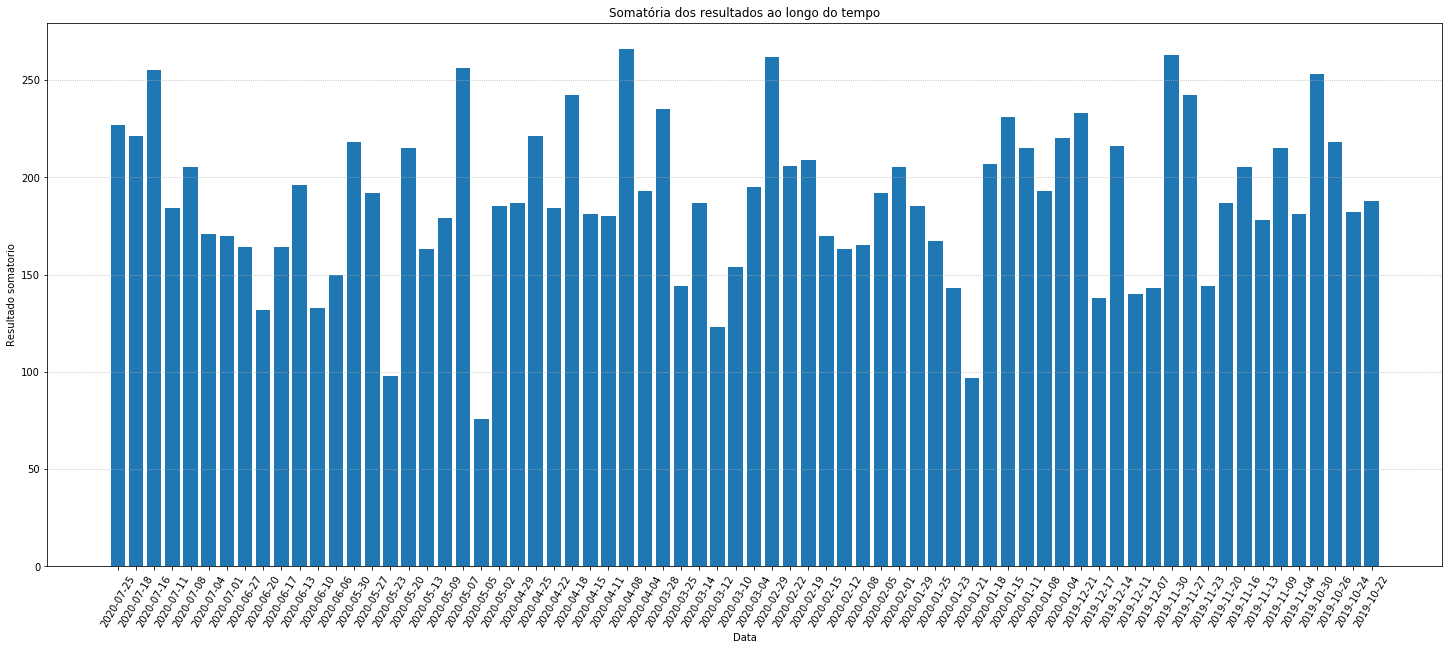

In [47]:
# plotar no gráfico
n_observ = 70

# Create the bars on the plot
plt.bar(x=range(n_observ), # start off with the xticks as numbers 0:19
        height=df[0:n_observ]['resultado_soma_total'])
# Change the xticks to the correct user ids
plt.xticks(range(n_observ), 
           df[0:n_observ]['data'], 
           rotation=60)

# Set up the x, y labels, titles, and linestyles etc.
plt.ylabel("Resultado somatorio")
plt.xlabel("Data")
plt.title("Somatória dos resultados ao longo do tempo")
plt.gca().yaxis.grid(linestyle=':')

In [ ]:
# Prevalência de números nos últimos sorteios

data_inicio, data_fim = getDataByIntervaloDias('2020-07-22', dias=100 )
print('parâmetros de data: ', data_inicio, data_fim) # debug

list_filtro_ex3 = list( filter(lambda a: a['data'] >= data_inicio
                                    and a['data'] <= data_fim
                                    and a['acumulado'] == 0
                              , df_list_raw) )

list_filtro_ex3[:1]

In [ ]:
# calcular a frequência de repetições entre 01 e 60 para cada coluna da matriz
list_frequencia_p1 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p1'], list_filtro_ex3)) )))} for x in range(1, 61) )
list_frequencia_p2 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p2'], list_filtro_ex3)) )))} for x in range(1, 61) )
list_frequencia_p3 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p3'], list_filtro_ex3)) )))} for x in range(1, 61) )
list_frequencia_p4 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p4'], list_filtro_ex3)) )))} for x in range(1, 61) )
list_frequencia_p5 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p5'], list_filtro_ex3)) )))} for x in range(1, 61) )
list_frequencia_p6 = list( {'numero':str(x).zfill(2), 'freq': len(list(filter(lambda b: b==str(x).zfill(2), list(map(lambda a: a['resultado_p6'], list_filtro_ex3)) )))} for x in range(1, 61) )

# calcular a somatória geral de repetições
list_frequencia = [list_frequencia_p1, list_frequencia_p2, list_frequencia_p3, list_frequencia_p4, list_frequencia_p5, list_frequencia_p6]
list_frequencia = list( {'numero': str(x).zfill(2), 'freq': sum(list(map(lambda g:g[x-1]['freq'], list_frequencia))) } for x in range(1, 61) )

#list_frequencia = list(filter(lambda a:a['freq'] > 0, list_frequencia)) # filtrar
list_frequencia = sorted(list_frequencia, key=(lambda o:o['freq']), reverse=True) # ordenar 
list_frequencia[:12]

### Estruturando lista com Pandas

In [ ]:
# criar um dataframe em pandas a partir da lista
df = pd.DataFrame(list_filtro_ex2) # df_list_raw
df.head(5)

In [ ]:
# importar biblioteca para plotar gráfico
import matplotlib as mpl
from matplotlib import pyplot as plt

# For output plots inline in notebook:
%matplotlib inline
# For interactive plot controls on MatplotLib output:
# %matplotlib notebook
# Set the default figure size for all inline plots
# (note: needs to be AFTER the %matplotlib magic)
plt.rcParams['figure.figsize'] = [25, 10]

In [ ]:
# plotar no gráfico
n_observ = 70

# Create the bars on the plot
plt.bar(x=range(n_observ), # start off with the xticks as numbers 0:19
        height=df[0:n_observ]['valor_acumulado'])
# Change the xticks to the correct user ids
plt.xticks(range(n_observ), 
           df[0:n_observ]['data'], 
           rotation=60)

# Set up the x, y labels, titles, and linestyles etc.
plt.ylabel("Valor arrecadado")
plt.xlabel("Data")
plt.title("valores arrecadado por periodo")
plt.gca().yaxis.grid(linestyle=':')

### Agrupamento dos numeros sorteados no pandas

In [ ]:
# df_period = pd.DataFrame(list( filter(lambda a: a['data'] >= '2017-01-01' and a['data'] <= '2020-08-11', df_list_raw) ))
df_period = pd.DataFrame(list_filtro_ex2)

df_period.corr(method='kendall')

In [ ]:
frq_p1 = df_period['resultado_p1'].value_counts()
frq_p2 = df_period['resultado_p2'].value_counts()
frq_p3 = df_period['resultado_p3'].value_counts()
frq_p4 = df_period['resultado_p4'].value_counts()
frq_p5 = df_period['resultado_p5'].value_counts()
frq_p6 = df_period['resultado_p6'].value_counts()

list_number_frq = []
for k in frq_p1.keys():
    list_number_frq.append({"numero":k, "freq":frq_p1[k]})

for k in frq_p2.keys():
    list_number_frq.append({"numero":k, "freq":frq_p2[k]})

for k in frq_p3.keys():
    list_number_frq.append({"numero":k, "freq":frq_p3[k]})

for k in frq_p4.keys():
    list_number_frq.append({"numero":k, "freq":frq_p4[k]})

for k in frq_p5.keys():
    list_number_frq.append({"numero":k, "freq":frq_p5[k]})

for k in frq_p6.keys():
    list_number_frq.append({"numero":k, "freq":frq_p6[k]})

    
df_list_number = pd.DataFrame(list_number_frq)

In [ ]:
df_ordered = df_list_number.groupby('numero').sum().sort_values(by=['freq'], ascending=True)
df_ordered.head(12)

# 2020-08-01 sorteado -> ['12', '10', '33', '07', '42', '01']

In [ ]:
df_ordered = df_list_number.groupby('numero').sum().sort_values(by=['freq'], ascending=False)
df_ordered.head(12)

# 2020-08-01 sorteado -> ['12', '10', '33', '07', '42', '01']